In [1]:
import os.path as osp
import os

import torch
from sklearn.metrics import average_precision_score, roc_auc_score
from torch.nn import Linear

from overflowDataset import OverFlowDataset
from torch_geometric.loader import TemporalDataLoader
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import NeighborLoader, LinkNeighborLoader
from tqdm import tqdm
from neighbor_sampler import NeighborSampler


In [24]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
__file__ = os.path.abspath('')
path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'overflow')
dataset = OverFlowDataset(path)
data = dataset[0]

print(data)

# # Ensure to only sample actual destination nodes as negatives.
# min_dst_idx, max_dst_idx = int(data.dst.min()), int(data.dst.max())
# train_data, val_data, test_data = data.train_val_test_split(
#     val_ratio=0.15, test_ratio=0.15)

# train_loader = TemporalDataLoader(train_data, batch_size=200)
# val_loader = TemporalDataLoader(val_data, batch_size=200)
# test_loader = TemporalDataLoader(test_data, batch_size=200)

Data(x=[63497050, 128], edge_index=[2, 63497050], edge_attr=[63497050])


In [2]:
from torch_geometric.datasets import JODIEDataset
from torch_geometric.data import Data

__file__ = os.path.abspath('')
path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'JODIE')
dataset = JODIEDataset(path, name='reddit')
data_orig = dataset[0]
unique_nodes = torch.unique(torch.cat((data_orig.src,data_orig.dst)))
data = Data(x=torch.arange(unique_nodes.numel()), edge_index=torch.stack([data_orig.src, data_orig.dst], dim=0), edge_attr=data_orig.msg,  timestamp=data_orig.t)
data

Data(x=[10984], edge_index=[2, 672447], edge_attr=[672447, 172], timestamp=[672447])

In [23]:
torch.stack([data_orig.src, data_orig.dst])

tensor([[    0,     1,     2,  ...,  1071,    10,  3687],
        [10000, 10001, 10002,  ..., 10129, 10008, 10119]])

In [34]:
data = Data(x=data_orig.msg, edge_index=torch.stack([data_orig.src, data_orig.dst]))

In [35]:
data

Data(x=[672447, 172], edge_index=[2, 672447])

In [37]:
temp_loader = NeighborLoader(data, num_neighbors=[5], input_nodes=data.edge_index[1])
c=0
for i in temp_loader:
  print(i)
  if c==100:
    break
  c+=1

Data(x=[6, 172], edge_index=[2, 5], input_id=[1], batch_size=1)
Data(x=[6, 172], edge_index=[2, 5], input_id=[1], batch_size=1)
Data(x=[6, 172], edge_index=[2, 5], input_id=[1], batch_size=1)
Data(x=[6, 172], edge_index=[2, 5], input_id=[1], batch_size=1)
Data(x=[6, 172], edge_index=[2, 5], input_id=[1], batch_size=1)
Data(x=[6, 172], edge_index=[2, 5], input_id=[1], batch_size=1)
Data(x=[6, 172], edge_index=[2, 5], input_id=[1], batch_size=1)
Data(x=[6, 172], edge_index=[2, 5], input_id=[1], batch_size=1)
Data(x=[6, 172], edge_index=[2, 5], input_id=[1], batch_size=1)
Data(x=[6, 172], edge_index=[2, 5], input_id=[1], batch_size=1)
Data(x=[6, 172], edge_index=[2, 5], input_id=[1], batch_size=1)
Data(x=[6, 172], edge_index=[2, 5], input_id=[1], batch_size=1)
Data(x=[5, 172], edge_index=[2, 5], input_id=[1], batch_size=1)
Data(x=[5, 172], edge_index=[2, 5], input_id=[1], batch_size=1)
Data(x=[6, 172], edge_index=[2, 5], input_id=[1], batch_size=1)
Data(x=[6, 172], edge_index=[2, 5], inpu

In [108]:
next(iter(temp_loader))

(1,
 tensor([0]),
 EdgeIndex(edge_index=tensor([], size=(2, 0), dtype=torch.int64), e_id=tensor([], dtype=torch.int64), size=(1, 1)))

In [ ]:
loader = LinkNeighborLoader(data, batch_size=1, num_neighbors=[10], )

In [ ]:
data.n_id = torch.arange(data.num_nodes)

In [3]:
from torch_geometric.data import Data
from torch_geometric.utils import *

# Example node features
x = torch.tensor([
    [0, 0, 1],
    [1, 0, 0],
    [0, 1, 0],
    [1, 1, 1]
], dtype=torch.float)

# Example edge indices
edge_index = torch.tensor([
    [0, 1, 2, 3, 1],
    [1, 2, 3, 0, 3]
], dtype=torch.long)

timestamps_edge = torch.tensor([1,2,3,4,5])
timestamps_node = torch.tensor([-1,-1,-1,-1])
# edge_index = torch.tensor([
#     [0,1],
#     [3,3]
# ], dtype=torch.long)

# print(edge_index)
# #edge_index = to_undirected(edge_index)
# print(edge_index)

# Create PyTorch Geometric data object
test_data = Data(x=x, edge_index=edge_index, ts_e=timestamps_edge, ts_n=timestamps_node)
test_data.n_id = torch.arange(len(x))
test_data

Data(x=[4, 3], edge_index=[2, 5], ts_e=[5], ts_n=[4], n_id=[4])

In [50]:
test_data.edge_index[0][2:]

tensor([2, 3, 1])

In [44]:
torch.stack([test_data.edge_index[0][2:], test_data.edge_index[1][2:]])

tensor([[2, 3, 1],
        [3, 0, 3]])

In [26]:
test_data.edge_index.size(1)

5

In [24]:
torch.index_select(test_data.edge_index, 1, torch.arange())

tensor([[0, 2],
        [1, 3]])

In [46]:
loader = LinkNeighborLoader(test_data, num_neighbors=[1], edge_label_index=test_data.edge_index)#, edge_label_time=timestamps, time_attr='ts')
for data in loader:
    print(data)
    print(data.n_id)
    #print(data)
    #print(data.x)
    #print(data.edge_index)
    #print(data.n_id)

Data(x=[3, 3], edge_index=[2, 2], ts_e=[2], ts_n=[3], n_id=[3], input_id=[1], edge_label_index=[2, 1])
tensor([0, 1, 3])
Data(x=[3, 3], edge_index=[2, 2], ts_e=[2], ts_n=[3], n_id=[3], input_id=[1], edge_label_index=[2, 1])
tensor([1, 2, 0])
Data(x=[3, 3], edge_index=[2, 2], ts_e=[2], ts_n=[3], n_id=[3], input_id=[1], edge_label_index=[2, 1])
tensor([2, 3, 1])
Data(x=[3, 3], edge_index=[2, 2], ts_e=[2], ts_n=[3], n_id=[3], input_id=[1], edge_label_index=[2, 1])
tensor([0, 3, 1])
Data(x=[4, 3], edge_index=[2, 2], ts_e=[2], ts_n=[4], n_id=[4], input_id=[1], edge_label_index=[2, 1])
tensor([1, 3, 0, 2])


In [27]:
loader = LinkNeighborLoader(test_data, num_neighbors=[1], edge_label_index=test_data.edge_index, edge_label_time=timestamps_edge, time_attr='ts_n')
for data in loader:
    print(data)
    print(data.batch)
    print(data.n_id)
    #print(data.edge_label_time)

Data(x=[4, 3], edge_index=[2, 2], ts_e=[2], ts_n=[4], n_id=[4], batch=[4], input_id=[1], edge_label_index=[2, 2], edge_label_time=[2])
tensor([0, 0, 0, 0])
tensor([0, 1, 3, 0])
Data(x=[4, 3], edge_index=[2, 2], ts_e=[2], ts_n=[4], n_id=[4], batch=[4], input_id=[1], edge_label_index=[2, 2], edge_label_time=[2])
tensor([0, 0, 0, 0])
tensor([1, 2, 0, 1])
Data(x=[4, 3], edge_index=[2, 2], ts_e=[2], ts_n=[4], n_id=[4], batch=[4], input_id=[1], edge_label_index=[2, 2], edge_label_time=[2])
tensor([0, 0, 0, 0])
tensor([2, 3, 1, 1])
Data(x=[4, 3], edge_index=[2, 2], ts_e=[2], ts_n=[4], n_id=[4], batch=[4], input_id=[1], edge_label_index=[2, 2], edge_label_time=[2])
tensor([0, 0, 0, 0])
tensor([3, 0, 2, 3])
Data(x=[4, 3], edge_index=[2, 2], ts_e=[2], ts_n=[4], n_id=[4], batch=[4], input_id=[1], edge_label_index=[2, 2], edge_label_time=[2])
tensor([0, 0, 0, 0])
tensor([1, 3, 0, 1])


In [10]:
n_loader = NeighborLoader(test_data, num_neighbors=[1], input_nodes=torch.flatten(test_data.edge_index.t()), batch_size=2)
for data in n_loader:
    #print(data)
    print(data.n_id)
    #print(data.edge_index)

tensor([0, 1, 3])
tensor([1, 2, 0])
tensor([2, 3, 1])
tensor([3, 0, 1])
tensor([1, 3, 0, 2])


In [49]:
temp_loader = NeighborSampler(test_data.edge_index, sizes=[1], batch_size=2)
for batch_size, ids, adjs in temp_loader:
    print(ids)
    #print(adjs)

tensor([0, 1, 3])
tensor([2, 3, 1])


In [96]:
temp_loader = NeighborSampler(test_data.edge_index, sizes=[1], batch_size=1)
for data in temp_loader:
    print(data)
    
    # for i in adjs.edge_index:
    #     print(ids[i[0]], ids[i[1]])

(1, tensor([0, 3]), EdgeIndex(edge_index=tensor([[1],
        [0]]), e_id=tensor([3]), size=(2, 1)))
(1, tensor([1, 0]), EdgeIndex(edge_index=tensor([[1],
        [0]]), e_id=tensor([0]), size=(2, 1)))
(1, tensor([2, 1]), EdgeIndex(edge_index=tensor([[1],
        [0]]), e_id=tensor([1]), size=(2, 1)))
(1, tensor([3, 1]), EdgeIndex(edge_index=tensor([[1],
        [0]]), e_id=tensor([4]), size=(2, 1)))


In [21]:
temp_loader = NeighborSampler(test_data.edge_index, sizes=[-1,-1], node_idx=test_data.n_id, batch_size=1)
for b in temp_loader:
    print(b[1])

tensor([0, 3, 1, 2])
tensor([1, 0, 3])
tensor([2, 1, 0])
tensor([3, 1, 2, 0])


In [9]:
class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.lin_src = Linear(in_channels, in_channels)
        self.lin_dst = Linear(in_channels, in_channels)
        self.lin_final = Linear(in_channels, 1)

    def forward(self, z_src, z_dst):
        h = self.lin_src(z_src) + self.lin_dst(z_dst)
        h = h.relu()
        return self.lin_final(h)

In [10]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = x.relu_()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    @torch.no_grad()
    def inference(self, x_all, subgraph_loader):
        pbar = tqdm(total=len(subgraph_loader.dataset) * len(self.convs))
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch:
        for i, conv in enumerate(self.convs):
            xs = []
            for batch in subgraph_loader:
                x = x_all[batch.n_id.to(x_all.device)].to(device)
                x = conv(x, batch.edge_index.to(device))
                if i < len(self.convs) - 1:
                    x = x.relu_()
                xs.append(x[:batch.batch_size].cpu())
                pbar.update(batch.batch_size)
            x_all = torch.cat(xs, dim=0)
        pbar.close()
        return x_all

In [42]:
sampleNum = data.num_nodes

In [48]:
train_loader = NeighborSampler(data.edge_index, sizes=[10,10], node_idx=data.edge_index[0][:sampleNum], batch_size=1000)

In [49]:
from functools import lru_cache

cacheMiss = 0

@lru_cache(maxsize=200000)
def get_value(key):
    global cacheMiss
    cacheMiss +=1

pbar = tqdm(total=sampleNum)
for step, (batch_size, ids, adjs) in enumerate(train_loader):
    for i in ids:
        get_value(int(i))
    pbar.update(batch_size)
pbar.close()


  0%|          | 197500/63497050 [01:37<8:41:39, 2022.35it/s] 


KeyboardInterrupt: 

In [33]:
info = get_value.cache_info()
info.hits + info.misses

7381991

In [32]:
def getHitRatio(info):
    return info.hits / (info.hits + info.misses)

print(getHitRatio(info))

0.8559357495830054


In [34]:
import random

indices = torch.tensor(random.sample(range(len(data.edge_index[0])), sampleNum))
indices = torch.tensor(indices)
sampled_values = data.edge_index[0][indices]


/tmp/ipykernel_1663896/3240484968.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indices = torch.tensor(indices)


In [35]:
random_loader = NeighborSampler(data.edge_index, sizes=[10,10], node_idx=sampled_values)

In [36]:
from functools import lru_cache

cacheMiss = 0

@lru_cache(maxsize=200000)
def get_value(key):
    global cacheMiss
    cacheMiss +=1

pbar = tqdm(total=sampleNum)
for step, (batch_size, ids, adjs) in enumerate(random_loader):
    for i in ids:
        get_value(int(i))
    pbar.update(1)
pbar.close()

print(cacheMiss)

100%|██████████| 100000/100000 [00:32<00:00, 3047.38it/s]

1760968


In [37]:
info = get_value.cache_info()
info.hits + info.misses

5728813

In [38]:
def getHitRatio(info):
    return info.hits / (info.hits + info.misses)

print(getHitRatio(info))

0.692612064663308


Text(0, 0.5, 'Cache hit ratio %')

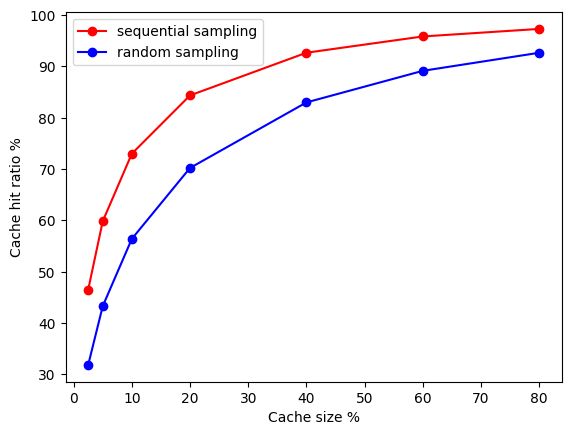

In [11]:
xs = [2.5, 5, 10, 20, 40, 60, 80]
sequent = [46.49, 59.83, 72.99, 84.35, 92.67, 95.84, 97.31]
rand = [31.82, 43.28, 56.39, 70.21, 82.98, 89.14, 92.66]

import numpy as np
import matplotlib.pyplot as plt

plt.plot(xs, sequent, 'o-', color='red', label="sequential sampling")
plt.plot(xs, rand, 'o-', color='blue', label="random sampling")
plt.legend()
plt.xlabel('Cache size %')
plt.ylabel('Cache hit ratio %')


In [25]:
import json
import os
import os.path as osp

datasets = ['overflow', 'wiki', 'reddit', 'taobao']
master_dict = {}

for i in datasets:
  __file__ = os.path.abspath('')
  path = osp.join(osp.realpath(__file__), 'cache_data', i)
  print(path)

  startName = path + "/meta_" + i + "_subset_100.0Cache_"
  if (i == 'taobao' or i == 'overflow'):
     startName = path + "/meta_" + i + "_subset_3.0Cache_"
  endName = "Size_10_5.json"

  fileNames = [startName + str(i) + endName for i in [2,5,10,20,40,60,80]]
  res = []
  for j in fileNames:
      with open(j) as json_file:
        data = json.load(json_file)
        res.append((data['LRUAccuracy'], data['StaticAccuracy'], data['LFUAccuracy'], data['ARCAccuracy']))
  master_dict[i] = res

/home/zz/Home/gnn/diss_caching/cache_data/overflow
/home/zz/Home/gnn/diss_caching/cache_data/wiki
/home/zz/Home/gnn/diss_caching/cache_data/reddit
/home/zz/Home/gnn/diss_caching/cache_data/taobao


Text(0, 0.5, 'Cache hit ratio %')

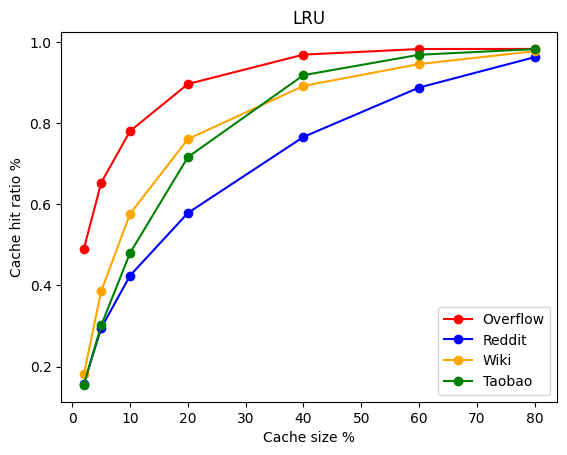

In [38]:
import numpy as np
import matplotlib.pyplot as plt

xs = [2, 5, 10, 20, 40, 60, 80]

# Reddit
reddit_LRUAccuracy = [i[0] for i in master_dict['reddit']]
reddit_LFUAccuracy = [i[2] for i in master_dict['reddit']]
reddit_ARCAccuracy = [i[3] for i in master_dict['reddit']]
reddit_StaticAccuracy = [i[1] for i in master_dict['reddit']]

# Wiki
wiki_LRUAccuracy = [i[0] for i in master_dict['wiki']]
wiki_LFUAccuracy = [i[2] for i in master_dict['wiki']]
wiki_ARCAccuracy = [i[3] for i in master_dict['wiki']]
wiki_StaticAccuracy = [i[1] for i in master_dict['wiki']]

# Taobao
taobao_LRUAccuracy = [i[0] for i in master_dict['taobao']]
taobao_LFUAccuracy = [i[2] for i in master_dict['taobao']]
taobao_ARCAccuracy = [i[3] for i in master_dict['taobao']]
taobao_StaticAccuracy = [i[1] for i in master_dict['taobao']]

# Overflow
LRUAccuracy = [i[0] for i in master_dict['overflow']]
LFUAccuracy = [i[2] for i in master_dict['overflow']]
ARCAccuracy = [i[3] for i in master_dict['overflow']]
StaticAccuracy = [i[1] for i in master_dict['overflow']]


plt.plot(xs, LRUAccuracy, 'o-', color='red', label="Overflow")
plt.plot(xs, reddit_LRUAccuracy, 'o-', color='blue', label="Reddit")
plt.plot(xs, wiki_LRUAccuracy, 'o-', color='orange', label="Wiki")
plt.plot(xs, taobao_LRUAccuracy, 'o-', color='green', label="Taobao")
plt.legend()
plt.title("LRU")
plt.xlabel('Cache size %')
plt.ylabel('Cache hit ratio %')

Text(0, 0.5, 'Cache hit ratio %')

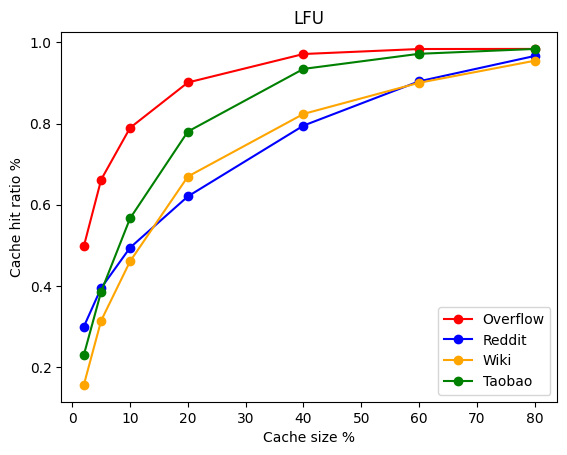

In [35]:
plt.plot(xs, LFUAccuracy, 'o-', color='red', label="Overflow")
plt.plot(xs, reddit_LFUAccuracy, 'o-', color='blue', label="Reddit")
plt.plot(xs, wiki_LFUAccuracy, 'o-', color='orange', label="Wiki")
plt.plot(xs, taobao_LFUAccuracy, 'o-', color='green', label="Taobao")
plt.legend()
plt.title("LFU")
plt.xlabel('Cache size %')
plt.ylabel('Cache hit ratio %')

Text(0, 0.5, 'Cache hit ratio %')

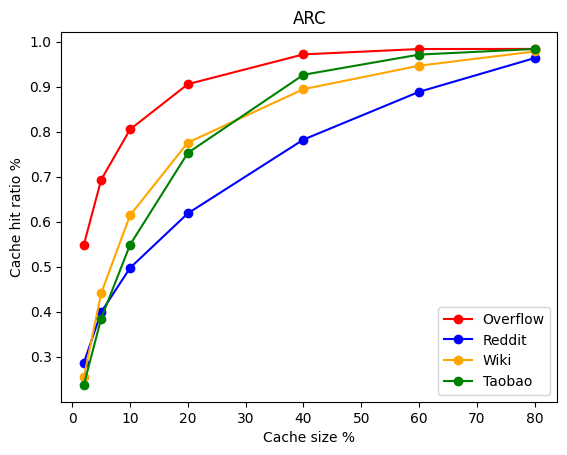

In [36]:
plt.plot(xs, ARCAccuracy, 'o-', color='red', label="Overflow")
plt.plot(xs, reddit_ARCAccuracy, 'o-', color='blue', label="Reddit")
plt.plot(xs, wiki_ARCAccuracy, 'o-', color='orange', label="Wiki")
plt.plot(xs, taobao_ARCAccuracy, 'o-', color='green', label="Taobao")
plt.legend()
plt.title("ARC")
plt.xlabel('Cache size %')
plt.ylabel('Cache hit ratio %')

Text(0, 0.5, 'Cache hit ratio %')

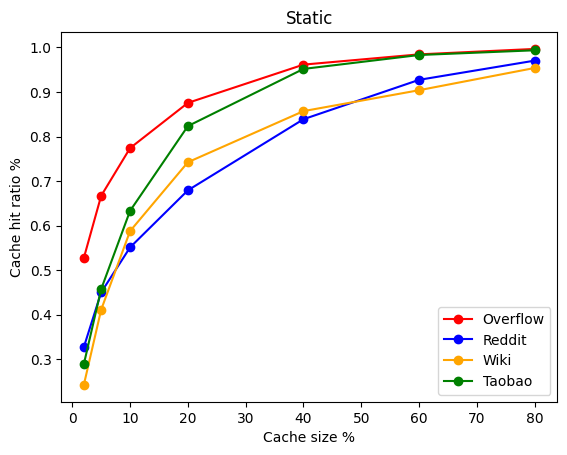

In [37]:
plt.plot(xs, StaticAccuracy, 'o-', color='red', label="Overflow")
plt.plot(xs, reddit_StaticAccuracy, 'o-', color='blue', label="Reddit")
plt.plot(xs, wiki_StaticAccuracy, 'o-', color='orange', label="Wiki")
plt.plot(xs, taobao_StaticAccuracy, 'o-', color='green', label="Taobao")
plt.legend()
plt.title("Static")
plt.xlabel('Cache size %')
plt.ylabel('Cache hit ratio %')

Text(0, 0.5, 'Cache hit ratio %')

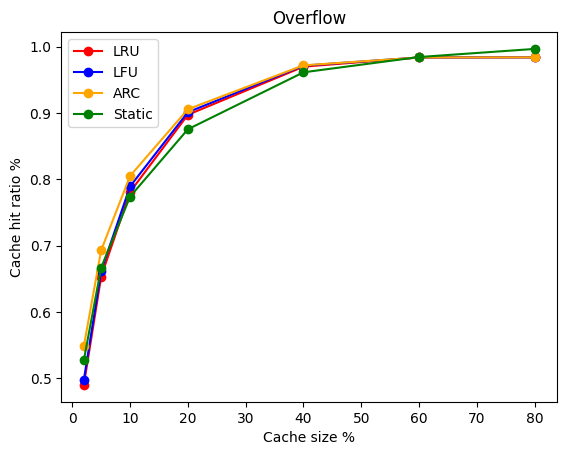

In [34]:
plt.plot(xs, LRUAccuracy, 'o-', color='red', label="LRU")
plt.plot(xs, LFUAccuracy, 'o-', color='blue', label="LFU")
plt.plot(xs, ARCAccuracy, 'o-', color='orange', label="ARC")
plt.plot(xs, StaticAccuracy, 'o-', color='green', label="Static")
plt.legend()
plt.title("Overflow")
plt.xlabel('Cache size %')
plt.ylabel('Cache hit ratio %')

Text(0, 0.5, 'Cache hit ratio %')

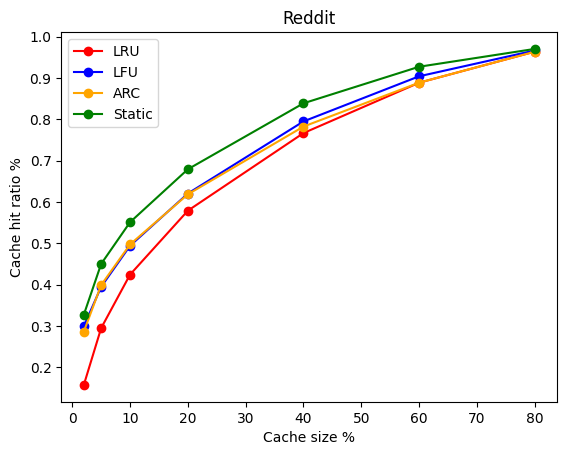

In [32]:
plt.plot(xs, reddit_LRUAccuracy, 'o-', color='red', label="LRU")
plt.plot(xs, reddit_LFUAccuracy, 'o-', color='blue', label="LFU")
plt.plot(xs, reddit_ARCAccuracy, 'o-', color='orange', label="ARC")
plt.plot(xs, reddit_StaticAccuracy, 'o-', color='green', label="Static")
plt.legend()
plt.title("Reddit")
plt.xlabel('Cache size %')
plt.ylabel('Cache hit ratio %')

Text(0, 0.5, 'Cache hit ratio %')

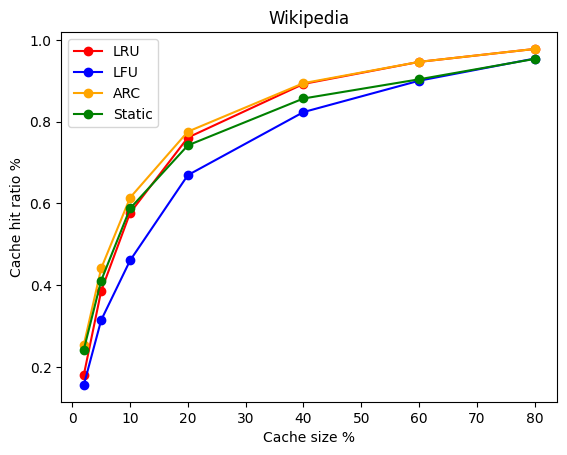

In [33]:
plt.plot(xs, wiki_LRUAccuracy, 'o-', color='red', label="LRU")
plt.plot(xs, wiki_LFUAccuracy, 'o-', color='blue', label="LFU")
plt.plot(xs, wiki_ARCAccuracy, 'o-', color='orange', label="ARC")
plt.plot(xs, wiki_StaticAccuracy, 'o-', color='green', label="Static")
plt.legend()
plt.title("Wikipedia")
plt.xlabel('Cache size %')
plt.ylabel('Cache hit ratio %')

Text(0, 0.5, 'Cache hit ratio %')

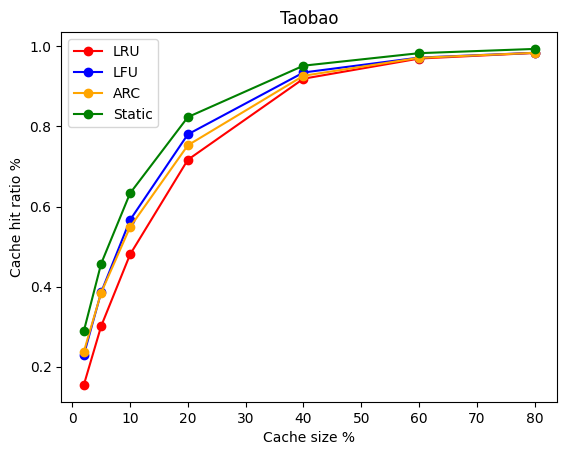

In [31]:
plt.plot(xs, taobao_LRUAccuracy, 'o-', color='red', label="LRU")
plt.plot(xs, taobao_LFUAccuracy, 'o-', color='blue', label="LFU")
plt.plot(xs, taobao_ARCAccuracy, 'o-', color='orange', label="ARC")
plt.plot(xs, taobao_StaticAccuracy, 'o-', color='green', label="Static")
plt.legend()
plt.title("Taobao")
plt.xlabel('Cache size %')
plt.ylabel('Cache hit ratio %')